## Практическое задание

Вариант 1. (простой)

- обучить сверточную нейронную сеть в стиле AlexNet (с падением размера ядра свертки и последовательностью блоков свертка-пулинг  (conv-pool)-(conv-pool)-...) на датасете fashion-mnist или cifar10
- оценить рост точности при увеличении ширины сети (больше ядер)
- оценить рост точности при увеличении глубины сети (больше слоев)
- (опциционально)сравнить с точностью полносвязной сети для этой выборки


Вариант 2. (сложный)
- реализовать нейронную сеть или стек из сверток (Concatenate) на сifar10.
- оценить рост точности при увеличении ширины сети (больше ядер), больше нитей.
- оценить рост точности при увеличении глубины сети (больше слоев)

In [ ]:
import tensorflow.keras as keras
import numpy as np
import os
import pandas as pd

from __future__ import print_function
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from matplotlib import pyplot as plt
from keras.layers import Input, Concatenate
from tensorflow.keras.utils import plot_model
from keras.models import Model

In [ ]:
classes=['самолет', 'автомобиль', 'птица', 'кот', 'олень', 'собака', 'лягушка', 'лошадь', 'корабль', 'грузовик']

In [ ]:
# установка параметров нейросети
batch_size = 64
num_classes = 10
epochs = 1
# num_predictions = 20

save_dir = os.path.join(os.getcwd(), 'saved_models')
model_name = 'keras_cifar10_trained_model.h5'

# разделение тренировочной и тестовой выборки
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'тренировочные примеры')
print(x_test.shape[0], 'тестовые примеры')

# преобразование матрицы чисел 0-9 в бинарную матрицу чисел 0-1
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)


x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255

x_train shape: (50000, 32, 32, 3)
50000 тренировочные примеры
10000 тестовые примеры


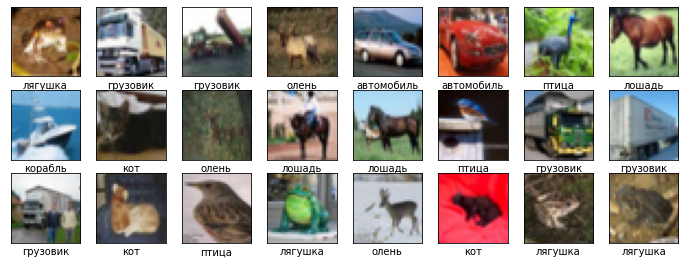

In [ ]:
plt.figure(figsize=(12,12))

for i in range(24):
    plt.subplot(8,8,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i].reshape(32,32,3), cmap=plt.cm.binary)
    plt.xlabel(classes[np.argmax(y_train[i])])
plt.show()

In [ ]:
# Будем делать data augmentation в реальном времени:

datagen = ImageDataGenerator(
    featurewise_center=False,
    samplewise_center=False,
    featurewise_std_normalization=False,
    samplewise_std_normalization=False,
    zca_whitening=False, 
    zca_epsilon=1e-06, 
    rotation_range=5, 
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0., 
    zoom_range=0., 
    channel_shift_range=0.,
    fill_mode='nearest',
    cval=0.,
    horizontal_flip=True,
    vertical_flip=False,
    rescale=None,
    preprocessing_function=None,
    data_format=None,
    validation_split=0.0)

In [ ]:
# Сюда будем собирать точность и ошибки для разных видов моделей
stats = []

## Модель 2-нити

In [ ]:
%%time

all_scores = []
all_losses = []

for i in range(5):
  print(f'Запуск модели {i+1}:')

  first_input = Input(shape=x_train.shape[1:])
  x11 = Conv2D(32, 3, activation='relu', padding = 'same')(first_input)
  x12 = Conv2D(64, 3, activation='relu', padding = 'same')(x11)
  first_dense = x12

  x21 = Conv2D(32, 5, activation='relu', padding = 'same')(first_input)
  x22 = Conv2D(64, 5, activation='relu', padding = 'same')(x21)
  second_dense = x22

  merge = Concatenate(axis = -1)([first_dense, second_dense])

  merge_flat = Flatten()(merge)
  merge_dense = Dense(512, activation='relu')(merge_flat)
  merge_class = Dense(10, activation='softmax')(merge_dense)

  model_2_bench = Model(inputs=first_input, outputs=merge_class)
  model_2_bench.compile(optimizer='SGD', 
                      loss=keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
  hist = model_2_bench.fit(datagen.flow(x_train, y_train,
                                     batch_size=batch_size), 
                         epochs = epochs, validation_data=(x_test, y_test))
  
  # проверка работы обученной модели
  scores = model_2_bench.evaluate(x_test, y_test, verbose=0)
  all_scores.append(scores[1])
  all_losses.append(scores[0])

stats.append(['2-нити', np.average(all_scores), np.std(all_scores)])
print(f'\nTest 2-нити - {np.average(all_scores):.3f} +- {np.std(all_scores):.3f}')

Запуск модели 1:
782/782 [==============================] - 57s 71ms/step - loss: 1.8645 - accuracy: 0.3300 - val_loss: 1.7004 - val_accuracy: 0.3867
Запуск модели 2:
782/782 [==============================] - 55s 69ms/step - loss: 1.8612 - accuracy: 0.3340 - val_loss: 1.6736 - val_accuracy: 0.4069
Запуск модели 3:
782/782 [==============================] - 54s 69ms/step - loss: 1.8569 - accuracy: 0.3377 - val_loss: 1.5800 - val_accuracy: 0.4439
Запуск модели 4:
782/782 [==============================] - 54s 69ms/step - loss: 1.8452 - accuracy: 0.3416 - val_loss: 1.5642 - val_accuracy: 0.4437
Запуск модели 5:
782/782 [==============================] - 55s 69ms/step - loss: 1.8752 - accuracy: 0.3254 - val_loss: 1.6399 - val_accuracy: 0.4208

Test 2-нити - 0.420 +- 0.022
CPU times: user 6min 41s, sys: 14.8 s, total: 6min 56s
Wall time: 5min 52s


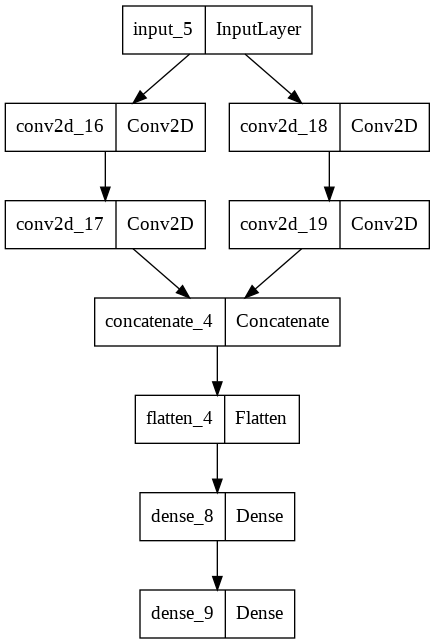

In [ ]:
plot_model(model_2_bench)

## Модель 3-нити

In [ ]:
%%time

all_scores = []
all_losses = []

for i in range(5):
  print(f'Запуск модели {i+1}:')

  first_input = Input(shape=x_train.shape[1:])
  x11 = Conv2D(32, 3, activation='relu', padding = 'same')(first_input)
  x12 = Conv2D(64, 3, activation='relu', padding = 'same')(x11)
  first_dense = x12

  x21 = Conv2D(32, 5, activation='relu', padding = 'same')(first_input)
  x22 = Conv2D(64, 5, activation='relu', padding = 'same')(x21)
  second_dense = x22

  merge_1 = Concatenate(axis = -1)([first_dense, second_dense])

  x31 = Conv2D(32,7, activation='relu', padding = 'same')(first_input)
  x32 = Conv2D(64,7, activation='relu', padding = 'same')(x31)

  merge_2 = Concatenate(axis = -1)([merge_1, x32])

  merge_flat = Flatten()(merge_2)
  merge_dense = Dense(512, activation='relu')(merge_flat)
  merge_class = Dense(10, activation='softmax')(merge_dense)

  model_3_bench = Model(inputs=first_input, outputs=merge_class)
  model_3_bench.compile(optimizer='SGD', 
                      loss=keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
  hist = model_3_bench.fit(datagen.flow(x_train, y_train,
                                     batch_size=batch_size), 
                         epochs = epochs, validation_data=(x_test, y_test))
  
  # проверка работы обученной модели
  scores = model_3_bench.evaluate(x_test, y_test, verbose=0)
  all_scores.append(scores[1])
  all_losses.append(scores[0])

stats.append(['3-нити', np.average(all_scores), np.std(all_scores)])
print(f'\nTest 3-нити - {np.average(all_scores):.3f} +- {np.std(all_scores):.3f}')

Запуск модели 1:
1563/1563 [==============================] - 48s 30ms/step - loss: 1.7627 - accuracy: 0.3661 - val_loss: 1.4326 - val_accuracy: 0.4889
Запуск модели 2:
1563/1563 [==============================] - 46s 29ms/step - loss: 1.7486 - accuracy: 0.3733 - val_loss: 1.4413 - val_accuracy: 0.4905
Запуск модели 3:
1563/1563 [==============================] - 47s 30ms/step - loss: 1.7377 - accuracy: 0.3777 - val_loss: 1.4099 - val_accuracy: 0.5014
Запуск модели 4:
1563/1563 [==============================] - 47s 30ms/step - loss: 1.7520 - accuracy: 0.3707 - val_loss: 1.4660 - val_accuracy: 0.4759
Запуск модели 5:
1563/1563 [==============================] - 47s 30ms/step - loss: 1.7416 - accuracy: 0.3748 - val_loss: 1.4406 - val_accuracy: 0.4832

Test 3-нити - 0.488 +- 0.008
CPU times: user 5min 48s, sys: 12.9 s, total: 6min 1s
Wall time: 4min 45s


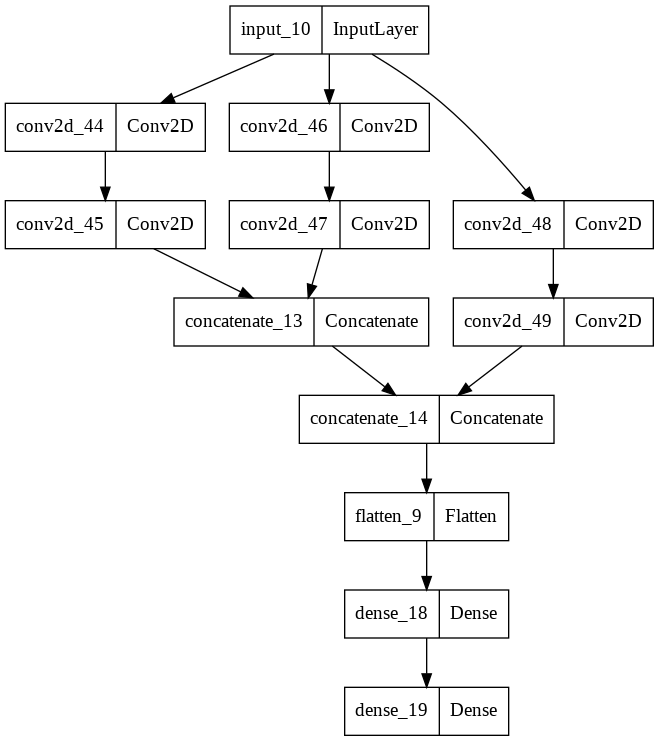

In [ ]:
plot_model(model_3_bench)

Дополнительная нить не добавляет модели точности.

## Модель 2-нити, больше ядер

In [ ]:
%%time

all_scores = []
all_losses = []

for i in range(5):
  print(f'Запуск модели {i+1}:')

  first_input = Input(shape=x_train.shape[1:])
  x11 = Conv2D(64, 3, activation='relu', padding = 'same')(first_input)
  x12 = Conv2D(128, 3, activation='relu', padding = 'same')(x11)
  first_dense = x12

  x21 = Conv2D(64, 5, activation='relu', padding = 'same')(first_input)
  x22 = Conv2D(128, 5, activation='relu', padding = 'same')(x21)
  second_dense = x22

  merge = Concatenate(axis = -1)([first_dense, second_dense])

  merge_flat = Flatten()(merge)
  merge_dense = Dense(512, activation='relu')(merge_flat)
  merge_class = Dense(10, activation='softmax')(merge_dense)

  model_2_bench = Model(inputs=first_input, outputs=merge_class)
  model_2_bench.compile(optimizer='SGD', 
                      loss=keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
  hist = model_2_bench.fit(datagen.flow(x_train, y_train,
                                     batch_size=batch_size), 
                         epochs = epochs, validation_data=(x_test, y_test))
  
  # проверка работы обученной модели
  scores = model_2_bench.evaluate(x_test, y_test, verbose=0)
  all_scores.append(scores[1])
  all_losses.append(scores[0])

stats.append(['2-нити больше ядер', np.average(all_scores), np.std(all_scores)])
print(f'\nTest 2-нити больше ядер - {np.average(all_scores):.3f} +- {np.std(all_scores):.3f}')

Запуск модели 1:
1563/1563 [==============================] - 54s 34ms/step - loss: 1.7698 - accuracy: 0.3675 - val_loss: 1.4594 - val_accuracy: 0.4814
Запуск модели 2:
1563/1563 [==============================] - 51s 32ms/step - loss: 1.7837 - accuracy: 0.3583 - val_loss: 1.4921 - val_accuracy: 0.4706
Запуск модели 3:
1563/1563 [==============================] - 54s 34ms/step - loss: 1.7677 - accuracy: 0.3639 - val_loss: 1.4817 - val_accuracy: 0.4693
Запуск модели 4:
1563/1563 [==============================] - 52s 33ms/step - loss: 1.7693 - accuracy: 0.3659 - val_loss: 1.4555 - val_accuracy: 0.4785
Запуск модели 5:
1563/1563 [==============================] - 53s 34ms/step - loss: 1.7861 - accuracy: 0.3601 - val_loss: 1.4857 - val_accuracy: 0.4652

Test 2-нити больше ядер - 0.473 +- 0.006
CPU times: user 6min 14s, sys: 11 s, total: 6min 25s
Wall time: 6min 7s


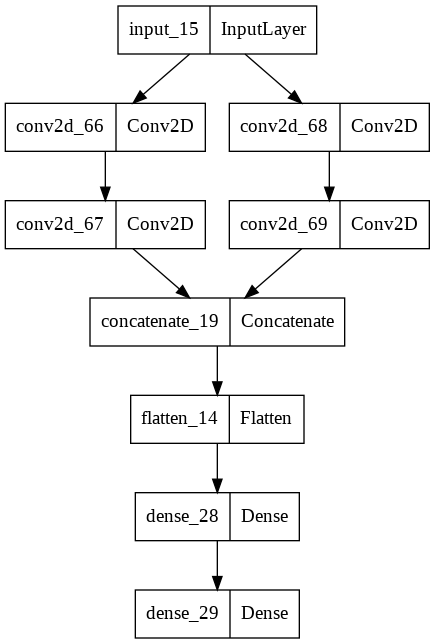

In [ ]:
plot_model(model_2_bench)

## Модель 3-нити, больше ядер

In [ ]:
%%time

all_scores = []
all_losses = []

for i in range(5):
  print(f'Запуск модели {i+1}:')

  first_input = Input(shape=x_train.shape[1:])
  x11 = Conv2D(64, 3, activation='relu', padding = 'same')(first_input)
  x12 = Conv2D(128, 3, activation='relu', padding = 'same')(x11)
  first_dense = x12

  x21 = Conv2D(64, 5, activation='relu', padding = 'same')(first_input)
  x22 = Conv2D(128, 5, activation='relu', padding = 'same')(x21)
  second_dense = x22

  merge_1 = Concatenate(axis = -1)([first_dense, second_dense])

  x31 = Conv2D(64,7, activation='relu', padding = 'same')(first_input)
  x32 = Conv2D(128,7, activation='relu', padding = 'same')(x31)

  merge_2 = Concatenate(axis = -1)([merge_1, x32])

  merge_flat = Flatten()(merge_2)
  merge_dense = Dense(512, activation='relu')(merge_flat)
  merge_class = Dense(10, activation='softmax')(merge_dense)

  model_3_bench = Model(inputs=first_input, outputs=merge_class)
  model_3_bench.compile(optimizer='SGD', 
                      loss=keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
  hist = model_3_bench.fit(datagen.flow(x_train, y_train,
                                     batch_size=batch_size), 
                         epochs = epochs, validation_data=(x_test, y_test))
  
  # проверка работы обученной модели
  scores = model_3_bench.evaluate(x_test, y_test, verbose=0)
  all_scores.append(scores[1])
  all_losses.append(scores[0])

stats.append(['3-нити больше ядер', np.average(all_scores), np.std(all_scores)])
print(f'\nTest 3-нити больше ядер - {np.average(all_scores):.3f} +- {np.std(all_scores):.3f}')

Запуск модели 1:
1563/1563 [==============================] - 87s 55ms/step - loss: 1.7506 - accuracy: 0.3708 - val_loss: 1.4182 - val_accuracy: 0.4904
Запуск модели 2:
1563/1563 [==============================] - 87s 55ms/step - loss: 1.7525 - accuracy: 0.3721 - val_loss: 1.4163 - val_accuracy: 0.4989
Запуск модели 3:
1563/1563 [==============================] - 87s 55ms/step - loss: 1.7617 - accuracy: 0.3670 - val_loss: 1.4881 - val_accuracy: 0.4735
Запуск модели 4:
1563/1563 [==============================] - 88s 56ms/step - loss: 1.7731 - accuracy: 0.3633 - val_loss: 1.4971 - val_accuracy: 0.4633
Запуск модели 5:
1563/1563 [==============================] - 87s 55ms/step - loss: 1.7635 - accuracy: 0.3665 - val_loss: 1.4807 - val_accuracy: 0.4684

Test 3-нити больше ядер - 0.479 +- 0.014
CPU times: user 8min 41s, sys: 14.3 s, total: 8min 55s
Wall time: 9min 32s


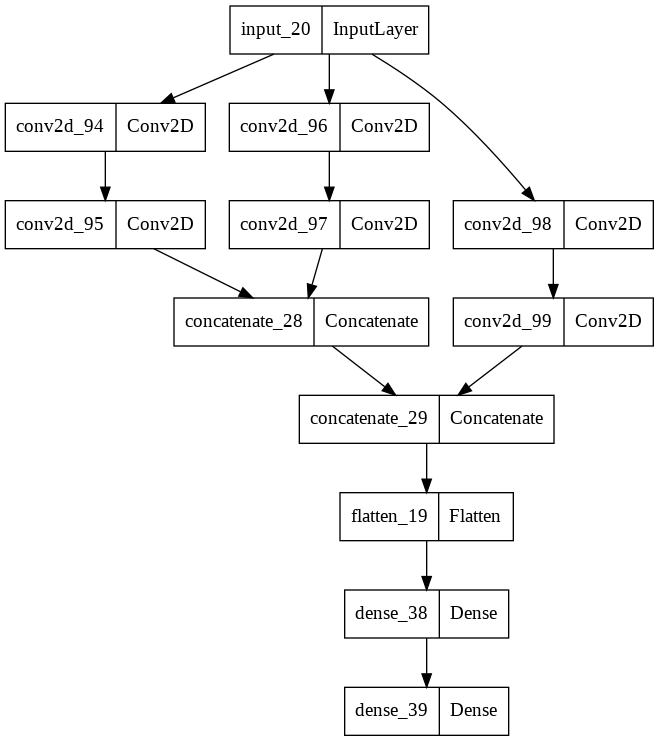

In [ ]:
plot_model(model_3_bench)

## Модель 2-нити, увеличена глубина

In [ ]:
%%time

all_scores = []
all_losses = []

for i in range(5):
  print(f'Запуск модели {i+1}:')

  first_input = Input(shape=x_train.shape[1:])
  x11 = Conv2D(32, 3, activation='relu', padding = 'same')(first_input)
  x12 = Conv2D(64, 3, activation='relu', padding = 'same')(x11)
  x13 = Conv2D(128, 3, activation='relu', padding = 'same')(x12)
  first_dense = x13

  x21 = Conv2D(32, 5, activation='relu', padding = 'same')(first_input)
  x22 = Conv2D(64, 5, activation='relu', padding = 'same')(x21)
  x23 = Conv2D(128, 5, activation='relu', padding = 'same')(x22)
  second_dense = x23

  merge = Concatenate(axis = -1)([first_dense, second_dense])

  merge_flat = Flatten()(merge)
  merge_dense = Dense(512, activation='relu')(merge_flat)
  merge_class = Dense(10, activation='softmax')(merge_dense)

  model_2_bench = Model(inputs=first_input, outputs=merge_class)
  model_2_bench.compile(optimizer='SGD', 
                      loss=keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
  hist = model_2_bench.fit(datagen.flow(x_train, y_train,
                                     batch_size=batch_size), 
                         epochs = epochs, validation_data=(x_test, y_test))
  
  # проверка работы обученной модели
  scores = model_2_bench.evaluate(x_test, y_test, verbose=0)
  all_scores.append(scores[1])
  all_losses.append(scores[0])

stats.append(['2-нити, увеличена глубина (больше слоев)', np.average(all_scores), np.std(all_scores)])
print(f'\nTest 2-нити, увеличена глубина (больше слоев) - {np.average(all_scores):.3f} +- {np.std(all_scores):.3f}')

Запуск модели 1:
1563/1563 [==============================] - 57s 36ms/step - loss: 1.7684 - accuracy: 0.3649 - val_loss: 1.4990 - val_accuracy: 0.4655
Запуск модели 2:
1563/1563 [==============================] - 56s 36ms/step - loss: 1.7803 - accuracy: 0.3589 - val_loss: 1.4683 - val_accuracy: 0.4705
Запуск модели 3:
1563/1563 [==============================] - 57s 36ms/step - loss: 1.7674 - accuracy: 0.3653 - val_loss: 1.4143 - val_accuracy: 0.4986
Запуск модели 4:
1563/1563 [==============================] - 58s 37ms/step - loss: 1.8040 - accuracy: 0.3510 - val_loss: 1.4716 - val_accuracy: 0.4768
Запуск модели 5:
1563/1563 [==============================] - 56s 36ms/step - loss: 1.7733 - accuracy: 0.3643 - val_loss: 1.5660 - val_accuracy: 0.4333

Test 2-нити, увеличена глубина (больше слоев) - 0.469 +- 0.021
CPU times: user 6min 37s, sys: 10.9 s, total: 6min 48s
Wall time: 5min 34s


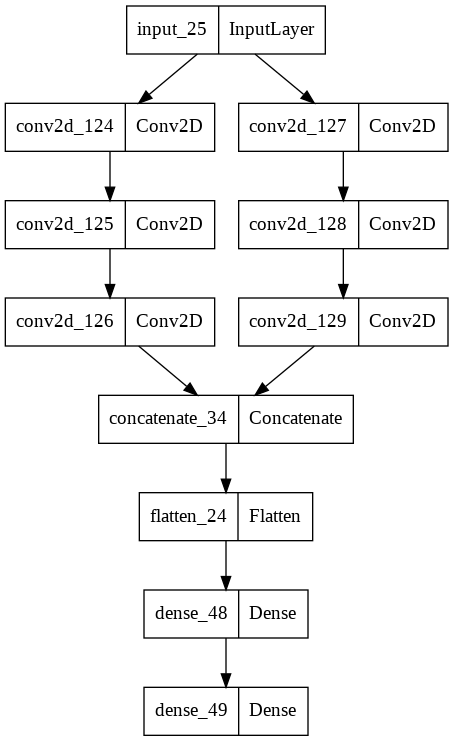

In [ ]:
plot_model(model_2_bench)

## Модель 3-нити, увеличена глубина

In [ ]:
%%time

all_scores = []
all_losses = []

for i in range(5):
  print(f'Запуск модели {i+1}:')

  first_input = Input(shape=x_train.shape[1:])
  x11 = Conv2D(32, 3, activation='relu', padding = 'same')(first_input)
  x12 = Conv2D(64, 3, activation='relu', padding = 'same')(x11)
  x13 = Conv2D(128, 3, activation='relu', padding = 'same')(x12)
  first_dense = x13

  x21 = Conv2D(32, 5, activation='relu', padding = 'same')(first_input)
  x22 = Conv2D(64, 5, activation='relu', padding = 'same')(x21)
  x23 = Conv2D(128, 5, activation='relu', padding = 'same')(x22)
  second_dense = x23

  merge_1 = Concatenate(axis = -1)([first_dense, second_dense])

  x31 = Conv2D(32,7, activation='relu', padding = 'same')(first_input)
  x32 = Conv2D(64,7, activation='relu', padding = 'same')(x31)
  x33 = Conv2D(128,7, activation='relu', padding = 'same')(x32)

  merge_2 = Concatenate(axis = -1)([merge_1, x33])

  merge_flat = Flatten()(merge_2)
  merge_dense = Dense(512, activation='relu')(merge_flat)
  merge_class = Dense(10, activation='softmax')(merge_dense)

  model_3_bench = Model(inputs=first_input, outputs=merge_class)
  model_3_bench.compile(optimizer='SGD', 
                      loss=keras.losses.CategoricalCrossentropy(),
                      metrics=['accuracy'])
  hist = model_3_bench.fit(datagen.flow(x_train, y_train,
                                     batch_size=batch_size), 
                         epochs = epochs, validation_data=(x_test, y_test))
  
  # проверка работы обученной модели
  scores = model_3_bench.evaluate(x_test, y_test, verbose=0)
  all_scores.append(scores[1])
  all_losses.append(scores[0])

stats.append(['3-нити, увеличена глубина (больше слоев)', np.average(all_scores), np.std(all_scores)])
print(f'\nTest 3-нити, увеличена глубина (больше слоев) - {np.average(all_scores):.3f} +- {np.std(all_scores):.3f}')

Запуск модели 1:
1563/1563 [==============================] - 99s 63ms/step - loss: 1.7573 - accuracy: 0.3679 - val_loss: 1.4240 - val_accuracy: 0.4810
Запуск модели 2:
1563/1563 [==============================] - 99s 63ms/step - loss: 1.7684 - accuracy: 0.3607 - val_loss: 1.4144 - val_accuracy: 0.4980
Запуск модели 3:
1563/1563 [==============================] - 98s 63ms/step - loss: 1.7682 - accuracy: 0.3654 - val_loss: 1.4445 - val_accuracy: 0.4809
Запуск модели 4:
1563/1563 [==============================] - 99s 63ms/step - loss: 1.7346 - accuracy: 0.3762 - val_loss: 1.4479 - val_accuracy: 0.4738
Запуск модели 5:
1563/1563 [==============================] - 99s 63ms/step - loss: 1.7417 - accuracy: 0.3715 - val_loss: 1.3980 - val_accuracy: 0.5013

Test 3-нити, увеличена глубина (больше слоев) - 0.487 +- 0.011
CPU times: user 9min 30s, sys: 15 s, total: 9min 45s
Wall time: 9min 24s


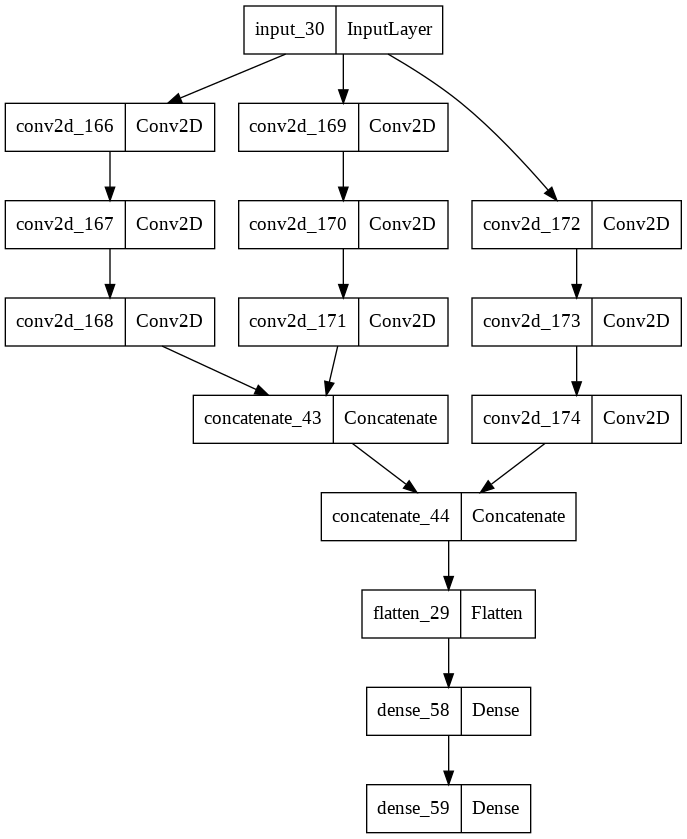

In [ ]:
plot_model(model_3_bench)

In [ ]:
df = pd.DataFrame(stats, columns=['Тип сети', 'Accuracy', 'Loss'])

In [ ]:
df.set_index('Тип сети')

,Accuracy,Loss
Тип сети,,
2-нити,0.46926,0.011432
3-нити,0.48798,0.008439
2-нити больше ядер,0.47300,0.006018
3-нити больше ядер,0.47890,0.013528
"2-нити, увеличена глубина (больше слоев)",0.46894,0.021100
"3-нити, увеличена глубина (больше слоев)",0.48700,0.010705


In [ ]:
Сильных увеличений точности все виды построенных сеток не дали. Попробуем увеличить количество эпох.

## Модель 2-нити

In [ ]:
epochs = 20

In [ ]:
%%time

all_scores = []
all_losses = []

# for i in range(5):
#   print(f'Запуск модели {i+1}:')

first_input = Input(shape=x_train.shape[1:])
x11 = Conv2D(32, 3, activation='relu', padding = 'same')(first_input)
x12 = Conv2D(64, 3, activation='relu', padding = 'same')(x11)
first_dense = x12

x21 = Conv2D(32, 5, activation='relu', padding = 'same')(first_input)
x22 = Conv2D(64, 5, activation='relu', padding = 'same')(x21)
second_dense = x22

merge = Concatenate(axis = -1)([first_dense, second_dense])

merge_flat = Flatten()(merge)
merge_dense = Dense(512, activation='relu')(merge_flat)
merge_class = Dense(10, activation='softmax')(merge_dense)

model_2_bench = Model(inputs=first_input, outputs=merge_class)
model_2_bench.compile(optimizer='SGD', 
                    loss=keras.losses.CategoricalCrossentropy(),
                    metrics=['accuracy'])
hist = model_2_bench.fit(datagen.flow(x_train, y_train,
                                    batch_size=batch_size), 
                        epochs = epochs, validation_data=(x_test, y_test))

# проверка работы обученной модели
scores = model_2_bench.evaluate(x_test, y_test, verbose=0)
all_scores.append(scores[1])
all_losses.append(scores[0])

stats.append(['2-нити', np.average(all_scores), np.std(all_scores)])
print(f'\nTest 2-нити - {np.average(all_scores):.3f} +- {np.std(all_scores):.3f}')

Epoch 1/20
1563/1563 [==============================] - 39s 25ms/step - loss: 1.7764 - accuracy: 0.3658 - val_loss: 1.5284 - val_accuracy: 0.4482
Epoch 2/20
1563/1563 [==============================] - 38s 24ms/step - loss: 1.4501 - accuracy: 0.4825 - val_loss: 1.3412 - val_accuracy: 0.5125
Epoch 3/20
1563/1563 [==============================] - 38s 24ms/step - loss: 1.3275 - accuracy: 0.5277 - val_loss: 1.1871 - val_accuracy: 0.5768
Epoch 4/20
1563/1563 [==============================] - 39s 25ms/step - loss: 1.2410 - accuracy: 0.5578 - val_loss: 1.1607 - val_accuracy: 0.5852
Epoch 5/20
1563/1563 [==============================] - 39s 25ms/step - loss: 1.1691 - accuracy: 0.5840 - val_loss: 1.1093 - val_accuracy: 0.6011
Epoch 6/20
1563/1563 [==============================] - 38s 24ms/step - loss: 1.1058 - accuracy: 0.6070 - val_loss: 1.0693 - val_accuracy: 0.6287
Epoch 7/20
1563/1563 [==============================] - 39s 25ms/step - loss: 1.0518 - accuracy: 0.6261 - val_loss: 1.0028 -

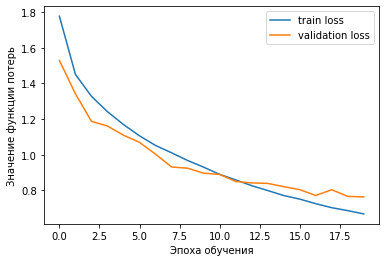

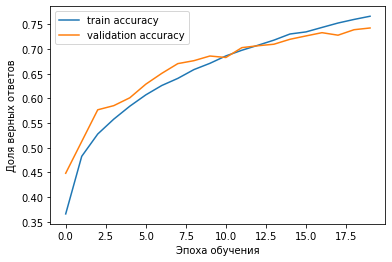

In [ ]:
plt.figure()
plt.plot(hist.history['loss'], label='train loss')
plt.plot(hist.history['val_loss'], label='validation loss')
plt.xlabel('Эпоха обучения')
plt.ylabel('Значение функции потерь')
plt.legend()

plt.figure()
plt.plot(hist.history['accuracy'], label='train accuracy')
plt.plot(hist.history['val_accuracy'], label='validation accuracy')
plt.xlabel('Эпоха обучения')
plt.ylabel('Доля верных ответов')
plt.legend()

plt.show()

Увеличение количества эпох увеличивает точность.